## Primeros pasos con TensorFlow

#### Goals
* Aprender las bases de TensorFlow 
* Usar la clase LinearRegressor para predecir el precio mediano
* Evaluar el rendimiento del modelo haciendo uso del RMSE 
* Mejorar la exactitud del modelo ajustando los hiperparametros

In [27]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [28]:
#cargamos el dataset
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

In [29]:
california_housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66900.0
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80100.0
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85700.0
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73400.0
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65500.0


In [30]:
#vamos a mover los datos de manera randomica
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))

#vamos a tratar los valores del median_house_value en miles para que todo sea mas facil
california_housing_dataframe["median_house_value"] /= 1000.0

#imprimimos el dataset
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
9072,-119.0,35.4,48.0,1908.0,331.0,789.0,321.0,3.6,84.6
14722,-122.2,37.8,28.0,3144.0,761.0,1737.0,669.0,2.9,140.5
2561,-117.7,34.1,46.0,1214.0,281.0,701.0,294.0,2.7,116.3
9820,-119.7,35.6,18.0,820.0,239.0,1345.0,207.0,2.1,47.5
5228,-118.1,34.7,31.0,2666.0,662.0,1337.0,602.0,2.4,101.1
...,...,...,...,...,...,...,...,...,...
4250,-118.0,33.8,26.0,1718.0,385.0,1022.0,368.0,3.9,196.1
12845,-121.8,38.0,25.0,3018.0,606.0,1614.0,568.0,3.5,127.0
2933,-117.8,33.7,14.0,4321.0,582.0,2025.0,578.0,8.4,355.1
8457,-118.5,34.1,40.0,3351.0,484.0,1564.0,523.0,8.5,500.0


In [31]:
#veremos un breve resumen estadistico del dataset
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


### Creacion del primer modelo 
Trataremos de predecir el valor de median_house_value (será nuestro target), usaremos el feature de total_rooms como atributo de entrada.
* Para realizar esta tarea usaremos la interfaz de LinearRegressor que proporciona la API de Estimator de TensorFlow. Esta API ocupa en gran medida el ajuste del modelo de bajo nivel.


<br>

#### Paso 1: Definimos atributos y configuramos las columnas de atributos
Para importar nuestros datos de entrenamiento en TensorFlow, debemos especificar que tipo de datos contiene cada atributo. Hay dos tipos de datos que usaremos:
* <b>Datos categoricos</b>: Datos que son textuales, en este dataset no hay este tipo de datos. (Ej: estilo de la casa)
* <b>Datos numéricos</b>: Datos que son un numero (entero o flotante) y que quieres tratar como un numero. A veces se quiere tratar los datos numericos (codigo postal) como si fuera categorico.

<br>
En TF se indica el tipo de datos a traves de un constructo denominado columna de atributos. Estos solo almacenan una descripcion de los datos de los atributos; no contienen los datos de los atributos en si.

Para comenzar usaremos solo un atributo de entrada numerica, total_rooms. A continuacion extraeremos los datos de total_rooms del dataset y definiremos la columna de atributos con numeric_column, el cual especifica que los datos son numericos.


In [32]:
#Definimos el atributo entrada: total_rooms
my_feature = california_housing_dataframe[["total_rooms"]]

In [33]:
my_feature

,total_rooms
9072,1908.0
14722,3144.0
2561,1214.0
9820,820.0
5228,2666.0
...,...
4250,1718.0
12845,3018.0
2933,4321.0
8457,3351.0


#### Paso 2:  Definimos el objetivo

In [34]:
#Configuramos nuestra columna de caractericas numerico para total_rooms
feature_columns = [tf.feature_column.numeric_column("total_rooms")]

In [35]:

feature_columns

[_NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [36]:
#Definimoa la etiqueta
targets = california_housing_dataframe["median_house_value"]

In [37]:
targets

9072     84.6
14722   140.5
2561    116.3
9820     47.5
5228    101.1
         ... 
4250    196.1
12845   127.0
2933    355.1
8457    500.0
8950    375.0
Name: median_house_value, Length: 17000, dtype: float64

In [38]:
targets.size

17000

#### Paso 3:  Configuramos el regresor lineal
Entrenaremos el modelo mediante el GradientDescentOptimizer, el cual usa SGD de minilote. El argumento learning_rate controla el tamaño del paso de gradiente.

<b>Nota:</b> Para estar seguros tambien haremos recorte de gradientes a nuestro optimizador a traves de <b>clip_gradients_by_norm</b>. Este recorte nos asegura que la magnitud de los gradientes no sea demasiado grande en el entrenamiento, lo cual puede provocar que falle el descenso de gradientes.


In [39]:
#Usamos la gradiente descendiente como optimizador para entrenar el modelo
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer,5.0)

In [40]:
#Configuramos el modelo de regresion lineal con nuestra columna de caracteristicas y optimizador
linear_regressor = tf.estimator.LinearRegressor(feature_columns =  feature_columns, optimizer = my_optimizer)

#### Paso 4: Definimos la funcion de entrada
Para importar nuestros datos de viviendas a nuestro Modelo, tenemos que definir una funcion de entrada, que instruye a TensorFlow como realizar el procesamiento pevio de los datos, ademas de como:
* Organizarlos por lotes
* Aleatorizarlos
* Repetirlos
Durante el entrenamiento del modelo.

<br>
<ol>
<li> Primero convertiremos nuestros datos de atributos de pandas a un diccionario de matrices de Numpy. </li>

<li> Usamos la API de conjunto de datos de TF para construir un objeto de conjunto de datos a partir de nuestros datos y luegom dividir nuestros datos en lotes de batch_size para que se repitan para el numero especificado de repeticiones (num_epochs). </li>
<li> Nuestra funcion de entrada construye una variable de iteracion para el conjunto de datos y devuelve el siguiente lote de datos al regresor lineal.</li>

In [41]:
def my_input_fn(features,targets,batch_size=1,shuffle=True,num_epochs=None):
    '''
    Entrenamiento de un modelo de regresion lineal de una caracteristica.
    Argumentos:
        features: Dataframe (pandas) de las caracteristicas
        targets: Dataframe (pandas) de los objetivos
        batch_size: Tamaño de los lotes que seran pasados al modelo
        shuffle: Verdadero o Falso, para barajear los datos.
        num_epochs: Numero de epochs para los cuales se deben repetir los datos. None = repetir indefinitivamente.
    
    Devuelve:
        Tuplas de (features,labels) para el siguiente lote de datos,
    '''
    
    #Convertimos los datos pandas en diccionarios de arrays numpy.
    features = {key:np.array(value) for key,value in dict(features).items()}
    
    #Constuimos un dataset, y configuramos el batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) #ojo: limite de 2GB?
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    #Barajeamos los datos, si es el caso
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    #Devolvemos el siguiente lote de datos
    features,labels = ds.make_one_shot_iterator().get_next()
    return features,labels
    

#### Paso 5: Entrena el modelo
Ahora llamamos a train() en nuetro linear_regressor para entrenar el modelo. Uniremos my_input_fn (la funcion de arriba) para poder pasar my_feature y target como argumentos y para comenzar entrenaremos el modelo para 100 pasos.

In [42]:
_ = linear_regressor.train(input_fn = lambda:my_input_fn(my_feature,targets),steps=100)

#### Paso 6: Evalua el modelo
Realizaremos predicciones sobre los datos de entrenamiento para ver que tan bien los ajusto nuestro modelo durante el entrenamiento. 
<b>OJO</b>: El error de entrenamiento mide que tan bien ajusta los datos de entrenamiento tu modelo. <b>NO</b> mide que tan bien el modelo realiza generalizaciones con respecto a los datos nuevos. 

In [43]:
'''
Creamos una funcion de entrada para las predicciones
Nota: Ya que estamos creando solo una prediccion para cada ejemplo, no necesitamos repetir o barajear los datos.
'''
prediction_input_fn = lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

#Llamamos a la funcion predict() en el linear_regressor para hacer predicciones
predictions = linear_regressor.predict(input_fn = prediction_input_fn)

#Definimos el formato de predicciones como un array Numpy, asi podemos calcular metricas de error
predictions = np.array([item['predictions'][0] for item in predictions])

#Imprimimos el Median Squared Error y el Root Mean Squared Error
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)

print("Mean Squared Error (en los datos de entrenamiento): %0.3f" %mean_squared_error)
print("Root Mean Squared Error (en los datos de entrenamiento): %0.3f" %root_mean_squared_error)

Mean Squared Error (en los datos de entrenamiento): 56367.025
Root Mean Squared Error (en los datos de entrenamiento): 237.417


¿Es un buen modelo?¿Como se determina la magnitud del error?
El MSE puede ser dificil de interpretar, es por es o que generalmente observamos el error de la raiz cuadrada de la media (RMSE) en su lugar. Algo interesante del RMSE es que se puede interpretar en la misma escala que los objetivos originales.

Comparemosel RMSE con la diferencia del min y del max de nuestros objetivos.
<br><br>

In [44]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difencia entre min y max: %0.3f" %min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difencia entre min y max: 485.002
Root Mean Squared Error: 237.417


El error abarca casi la mitad del rango de los valores objetivo ¿se puede obtener un mejor desempeño?
<br>
¿como reducimos el modelo?
* Lo primero que debemos ver es que tan cercanos son las predicciones con los valores objetivo.

In [45]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


Es posible que cause util, pero como se relacionan el RMSE y el valor medio, que ocurre con los difrentes cuartiles?
<br>
La regresion lineal en un solo atributo puede representarse como una linea que asigna la entrada x y la salida y.
Primero obtendremos una muestra aleatoria uniforme de los datos para poder realizar una representacion de dispersion que se pueda leer.


In [46]:
sample = california_housing_dataframe.sample(n=300)

Representaremos la linea que aprendimos, dibujandola a partir de la ordeanada del origen y la ponderacion del atributo del modelo , junto con la representacion de la dispersion, la linea sera de color rojo.

In [47]:
#Obtener el min y max de los valores de total_rooms
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

In [48]:
#Recuperamos el peso final y bias generados durante el entrenamiento 
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

In [49]:
#Obtenemos los valores pronosticados para los valores min y max
y_0 = (weight * x_0) + bias
y_1 = (weight * x_1) + bias

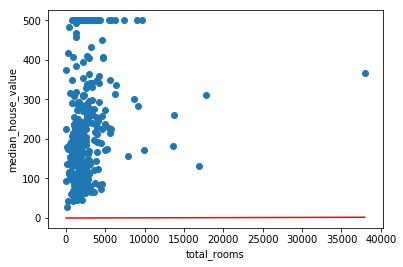

In [50]:
#Trazamos la linea dese (x_0,y_0) a (x_1,y_1)
plt.plot([x_0,x_1],[y_0,y_1],c='r')

#Etiquetamos los ejes
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

#trazamos un diagramade dispersion 
plt.scatter(sample["total_rooms"], sample["median_house_value"])


plt.show()

Se puede observar que la linea esta muy alejada de los datos.

### Ajuste de los hiperparametros
